**TEAM DETAILS**


Name: **Nithin Goud Kaira**

UBIT name:nithingo

UBIT person number:50469222





Name: **Kavya Sreeja Naidu Motupalli**

UBIT name:kavyasre

UBIT person number:50465235





Name: **Danussh Garlapati**

UBIT name:danusshg

UBIT person number:50477939

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split 
import tensorflow_datasets as tfds

from tensorflow.keras.datasets import cifar10, cifar100

***For CIFAR 10 Dataset***

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()



train_labels_categorical = tf.keras.utils.to_categorical(y_train, num_classes=10, dtype='uint8')

test_labels_categorical = tf.keras.utils.to_categorical(y_test, num_classes=10, dtype='uint8')

train_images, validation_images, train_labels, valid_labels = train_test_split(x_train, train_labels_categorical, test_size=0.20, 
                                                            stratify=train_labels_categorical, 
                                                            random_state=21) 




training_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
validation_data = tf.data.Dataset.from_tensor_slices((validation_images, valid_labels))
test_data = tf.data.Dataset.from_tensor_slices((x_test, test_labels_categorical))




train_data_batches = training_data.shuffle(buffer_size=30000).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE )
valid_data_batches = validation_data.shuffle(buffer_size=10000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE )
test_data_batches = test_data.shuffle(buffer_size=10000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE )


data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2), 
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
  layers.experimental.preprocessing.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
])


train_datas = (training_data.shuffle(40000).batch(128).map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE ).prefetch(tf.data.AUTOTUNE ))
valid_datas = (validation_data.shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE ))

In [ ]:
class PositionalEmbeddings(layers.Layer):

  def __init__(self, positional_embeddings_init=None, **kwargs):
    super().__init__(**kwargs)
    self.positional_embeddings_init = positional_embeddings_init

  def build(self, inputs_shape):
    positional_embeddings_shape = (1, inputs_shape[1], inputs_shape[2])
    self.positional_embeddings = self.add_weight('pos_embedding', positional_embeddings_shape, initializer=self.positional_embeddings_init)

  def call(self, inputs, inputs_positions=None):
    positional_embedding = tf.cast(self.positional_embeddings, inputs.dtype)

    return inputs + positional_embedding



In [ ]:
class VisionTransformer:
  def __init__(self):
    self.transformer_layers = 6
    self.patch_size = 4
    self.hidden_size = 64
    self.num_heads = 4
    self.mlp_dim = 128
    self.rescale = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])
  
  def layer_rescale(self,x):
    return self.rescale(x)
  
  def patch_generate(self,x):
    patches = layers.Conv2D(filters=self.hidden_size, kernel_size=self.patch_size, strides=self.patch_size, padding='valid')(x)
    row_axis, col_axis = (1, 2) 
    seq_len = (x.shape[row_axis] // self.patch_size) * (x.shape[col_axis] // self.patch_size)
    x = tf.reshape(patches, [-1, seq_len, self.hidden_size])
    return x
  
  def mlp(self,inputs):
    x = layers.Dense(units=self.mlp_dim, activation=tf.nn.gelu)(inputs)
    x = layers.Dropout(rate=0.1)(x) 
    x = layers.Dense(units=inputs.shape[-1], activation=tf.nn.gelu)(x)
    x = layers.Dropout(rate=0.1)(x)
    return x
  
  def EncoderBlock(self,inputs):
    x = layers.LayerNormalization(dtype=inputs.dtype)(inputs)
    x = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=inputs.shape[-1], dropout=0.1)(x, x) 
    x = layers.Add()([x, inputs]) 
    
    y = layers.LayerNormalization(dtype=x.dtype)(x)
    y = self.mlp(y)
    y2 = layers.Add()([y, x]) 
    return y2

  
  
  def Encoder(self, x):
    x = PositionalEmbeddings(positional_embeddings_init=tf.keras.initializers.RandomNormal(stddev=0.02), name='posembed_input')(x)
    x = layers.Dropout(rate=0.2)(x)
    for _ in range(self.transformer_layers):
      x = self.EncoderBlock(x)

    encoded = layers.LayerNormalization(name='encoder_norm')(x)
    return encoded
  
  def build_model(self,num_classes):
    inputs = layers.Input(shape=train_images.shape[1:])
    rescale = self.layer_rescale(inputs)

    patches = self.patch_generate(rescale)


    encoder_out = self.Encoder(patches)  


    im_representation = tf.reduce_mean(encoder_out, axis=1)  

    logits = layers.Dense(units=num_classes, name='head', kernel_initializer=tf.keras.initializers.zeros)(im_representation) 

    final_model = tf.keras.Model(inputs = inputs, outputs = logits)
    return final_model

In [ ]:
vision_tranformer = VisionTransformer()
model = vision_tranformer.build_model(10)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sequential_1 (Sequential)      (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 8, 8, 64)     3136        ['sequential_1[0][0]']           
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 64, 64)       0           ['conv2d[0][0]']                 
                                                                                              

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

with tf.device('/GPU:0'):
  history = model.fit(train_datas, epochs = 10, validation_data=valid_datas)

Epoch 1/10
313/313 [==============================] - 54s 84ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 2/10
313/313 [==============================] - 25s 79ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 3/10
313/313 [==============================] - 26s 84ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 4/10
313/313 [==============================] - 25s 79ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 5/10
313/313 [==============================] - 25s 78ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 6/10
313/313 [==============================] - 25s 78ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 7/10
313/313 [==============================] - 27s 86ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 8/10
313/313 [==============

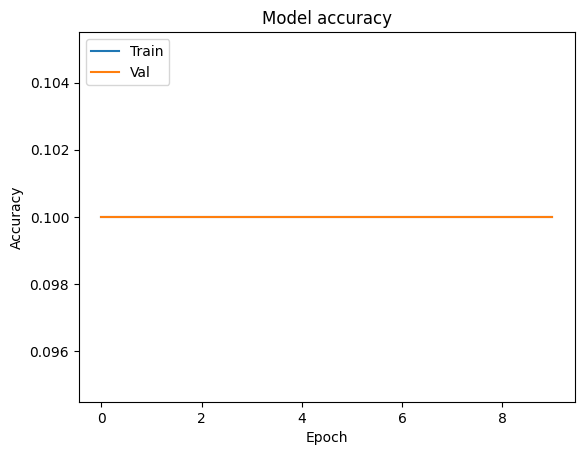

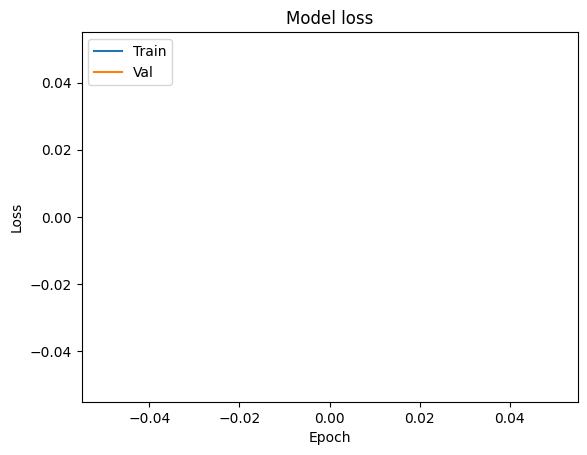

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

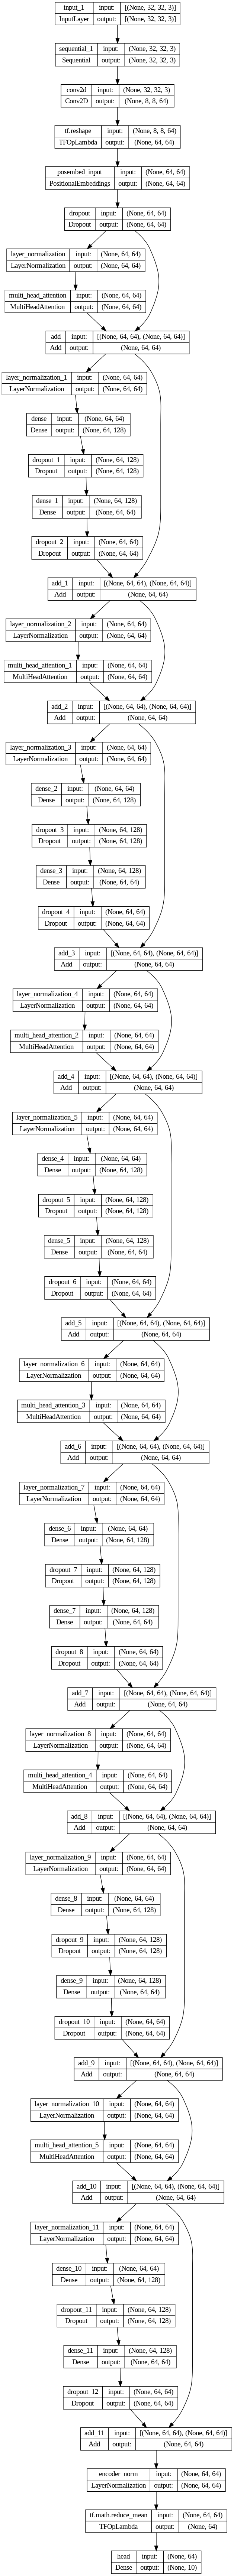

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

***For CIFAR 100 Dataset***

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()



train_labels_categorical = tf.keras.utils.to_categorical(y_train, num_classes=100, dtype='uint8')

test_labels_categorical = tf.keras.utils.to_categorical(y_test, num_classes=100, dtype='uint8')

train_images, validation_images, train_labels, valid_labels = train_test_split(x_train, train_labels_categorical, test_size=0.20, 
                                                            stratify=train_labels_categorical, 
                                                            random_state=21, shuffle = True) 




training_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
validation_data = tf.data.Dataset.from_tensor_slices((validation_images, valid_labels))
test_data = tf.data.Dataset.from_tensor_slices((x_test, test_labels_categorical))




train_data_batches = training_data.shuffle(buffer_size=30000).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE )
valid_data_batches = validation_data.shuffle(buffer_size=10000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE )
test_data_batches = test_data.shuffle(buffer_size=10000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE )


data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2), 
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
  layers.experimental.preprocessing.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
])


train_datas = (training_data.shuffle(40000).batch(128).map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE ).prefetch(tf.data.AUTOTUNE ))
valid_datas = (validation_data.shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE ))

169001437/169001437 [==============================] - 6s 0us/step


In [ ]:
class PositionalEmbeddings(layers.Layer):

  def __init__(self, positional_embeddings_init=None, **kwargs):
    super().__init__(**kwargs)
    self.positional_embeddings_init = positional_embeddings_init

  def build(self, inputs_shape):
    positional_embeddings_shape = (1, inputs_shape[1], inputs_shape[2])
    self.positional_embeddings = self.add_weight('pos_embedding', positional_embeddings_shape, initializer=self.positional_embeddings_init)

  def call(self, inputs, inputs_positions=None):
    positional_embedding = tf.cast(self.positional_embeddings, inputs.dtype)

    return inputs + positional_embedding



In [ ]:
class VisionTransformer:
  def __init__(self):
    self.transformer_layers = 6
    self.patch_size = 4
    self.hidden_size = 64
    self.num_heads = 4
    self.mlp_dim = 128
    self.rescale = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])
  
  def layer_rescale(self,x):
    return self.rescale(x)
  
  def patch_generate(self,x):
    patches = layers.Conv2D(filters=self.hidden_size, kernel_size=self.patch_size, strides=self.patch_size, padding='valid')(x)
    row_axis, col_axis = (1, 2) 
    seq_len = (x.shape[row_axis] // self.patch_size) * (x.shape[col_axis] // self.patch_size)
    x = tf.reshape(patches, [-1, seq_len, self.hidden_size])
    return x
  
  def mlp(self,inputs):
    x = layers.Dense(units=self.mlp_dim, activation=tf.nn.gelu)(inputs)
    x = layers.Dropout(rate=0.1)(x) 
    x = layers.Dense(units=inputs.shape[-1], activation=tf.nn.gelu)(x)
    x = layers.Dropout(rate=0.1)(x)
    return x
  
  def EncoderBlock(self,inputs):
    x = layers.LayerNormalization(dtype=inputs.dtype)(inputs)
    x = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=inputs.shape[-1], dropout=0.1)(x, x) 
    x = layers.Add()([x, inputs]) 
    
    y = layers.LayerNormalization(dtype=x.dtype)(x)
    y = self.mlp(y)
    y2 = layers.Add()([y, x]) 
    return y2

  
  
  def Encoder(self, x):
    x = PositionalEmbeddings(positional_embeddings_init=tf.keras.initializers.RandomNormal(stddev=0.02), name='posembed_input')(x)
    x = layers.Dropout(rate=0.2)(x)
    for _ in range(self.transformer_layers):
      x = self.EncoderBlock(x)

    encoded = layers.LayerNormalization(name='encoder_norm')(x)
    return encoded
  
  def build_model(self,num_classes):
    inputs = layers.Input(shape=train_images.shape[1:])
    rescale = self.layer_rescale(inputs)

    patches = self.patch_generate(rescale)


    encoder_out = self.Encoder(patches)  


    im_representation = tf.reduce_mean(encoder_out, axis=1)  

    logits = layers.Dense(units=num_classes, name='head', kernel_initializer=tf.keras.initializers.zeros)(im_representation) 

    final_model = tf.keras.Model(inputs = inputs, outputs = logits)
    return final_model

In [ ]:
vision_tranformer = VisionTransformer()
model = vision_tranformer.build_model(100)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

with tf.device('/GPU:0'):
  history = model.fit(train_datas, epochs = 10, validation_data=valid_datas)

Epoch 1/10
313/313 [==============================] - 47s 84ms/step - loss: nan - accuracy: 0.0100 - val_loss: nan - val_accuracy: 0.0100
Epoch 2/10
313/313 [==============================] - 25s 81ms/step - loss: nan - accuracy: 0.0100 - val_loss: nan - val_accuracy: 0.0100
Epoch 3/10
313/313 [==============================] - 25s 80ms/step - loss: nan - accuracy: 0.0100 - val_loss: nan - val_accuracy: 0.0100
Epoch 4/10
313/313 [==============================] - 25s 79ms/step - loss: nan - accuracy: 0.0100 - val_loss: nan - val_accuracy: 0.0100
Epoch 5/10
313/313 [==============================] - 25s 80ms/step - loss: nan - accuracy: 0.0100 - val_loss: nan - val_accuracy: 0.0100
Epoch 6/10
313/313 [==============================] - 25s 79ms/step - loss: nan - accuracy: 0.0100 - val_loss: nan - val_accuracy: 0.0100
Epoch 7/10
313/313 [==============================] - 25s 80ms/step - loss: nan - accuracy: 0.0100 - val_loss: nan - val_accuracy: 0.0100
Epoch 8/10
313/313 [==============

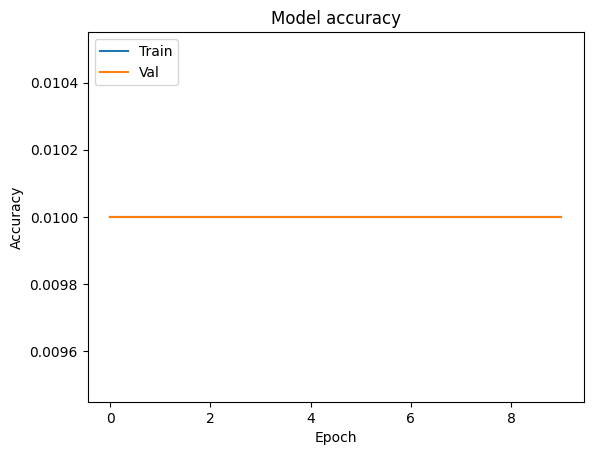

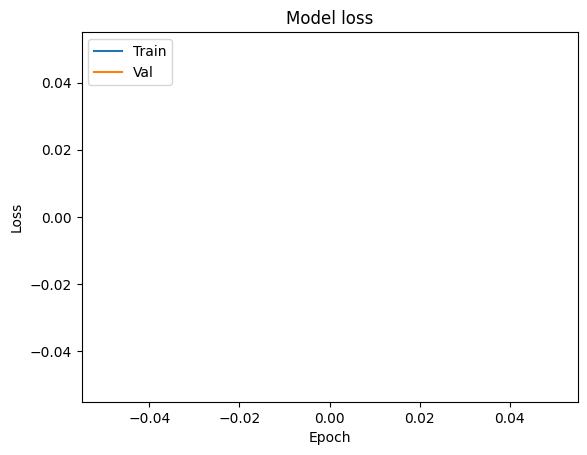

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()